# Politifact

In [ ]:
import os
base_dir = os.getcwd() + '/'
print('Base Dir:', base_dir)

Base Dir: /home/local/ASUAD/mkarami/Documents/Motivational Factors/


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
import torch
input_ids_politifact = torch.load(base_dir+'cache/input_ids_politifact_users')
attention_masks_politifact = torch.load(base_dir+'cache/attention_masks_politifact_users')
labels_politifact = torch.load(base_dir+'cache/labels_politifact_users')

print(input_ids_politifact[0])
print(attention_masks_politifact.size())
print(labels_politifact.size())

tensor([  101,  4938,  8945,  3126, 21351,  2078,  2179,  2757,  1010,  6086,
         7207,  2015,  1010, 11417, 15493,  1010,  2784,  2110, 10812,  6086,
         1024,  3081, 17328,  2703,  4575,  2074,  3936,  2010,  2784,  2110,
         4707,  2007,  6745,  4861,  1024,  3081,  8174,  2231,  2435,  8112,
        14895,  2015,  1523, 15940,  2015,  1011,  2440,  1997, 15565,  1524,
         1010,  2758,  4654,  1011,  2880,  1024,  3081,  5230, 15742,  3603,
         2006,  2455,  4198,  2000,  7207,  3192,  1024,  3081,  9295,  7207,
         1056, 28394,  3215,  1005, 10733,  5867,  2003,  2613,  1005,  1024,
         3081,  2192, 15773,  8112,  3602,  2179,  2008,  6083,  2002,  2001,
         2112,  1997, 18520,  3104,  1011,  2039,  1024,  3081,  2054,  3653,
         2015,  8398,  2074,  4197,  2041,  2055,  1996,  6965,  5690,  2097,
         2031, 26774,  1521,  1055,  4308,  1999,  9439,  1024,  3081,  1996,
         2995,  4767,  1997,  1053,  2019,  2239,  2038,  2042, 

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids_politifact, attention_masks_politifact, labels_politifact)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
valid_loader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )



print('Train = %d (%d) | Validation = %d (%d)' %(len(train_dataset), len(train_loader), len(valid_dataset), len(valid_loader)))

17,003 training samples
1,890 validation samples
Train = 17003 (2126) | Validation = 1890 (237)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    model = model.to(device)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, pred_flat)

def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, pred_flat)

def flat_f1_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

In [ ]:
import random
import numpy as np
from tqdm import tqdm

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

sentence_embedding_train = []
sentence_embedding_val = []


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits, hidden_states_train = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
#         token_vecs = hidden_states_train[-2][0]

        # Calculate the average of all 22 token vectors.
#         sentence_embedding_train.append(torch.mean(token_vecs, dim=0))
        
        

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
    
    

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_loader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_loader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits, hidden_states_val) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        
#         token_vecs = hidden_states_val[-2][0]
            # Calculate the average of all 22 token vectors.
#         sentence_embedding_val.append(torch.mean(token_vecs, dim=0))
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_precision += flat_precision(logits, label_ids)
        total_eval_recall += flat_recall(logits, label_ids)
        total_eval_f1 += flat_f1_score(logits, label_ids)
    
       

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_precision = total_eval_precision / len(valid_loader)
    avg_val_recall = total_eval_recall / len(valid_loader)
    avg_val_f1 = total_eval_f1 / len(valid_loader)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_loader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Valid. Prec': avg_val_precision,
            'Valid. Recall': avg_val_recall,
            'Valid. F1': avg_val_f1,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    50  of  2,126.    Elapsed: 0:00:09.
  Batch   100  of  2,126.    Elapsed: 0:00:18.
  Batch   150  of  2,126.    Elapsed: 0:00:27.
  Batch   200  of  2,126.    Elapsed: 0:00:36.
  Batch   250  of  2,126.    Elapsed: 0:00:46.
  Batch   300  of  2,126.    Elapsed: 0:00:55.
  Batch   350  of  2,126.    Elapsed: 0:01:04.
  Batch   400  of  2,126.    Elapsed: 0:01:14.
  Batch   450  of  2,126.    Elapsed: 0:01:23.
  Batch   500  of  2,126.    Elapsed: 0:01:32.
  Batch   550  of  2,126.    Elapsed: 0:01:42.
  Batch   600  of  2,126.    Elapsed: 0:01:51.
  Batch   650  of  2,126.    Elapsed: 0:02:00.
  Batch   700  of  2,126.    Elapsed: 0:02:10.
  Batch   750  of  2,126.    Elapsed: 0:02:19.
  Batch   800  of  2,126.    Elapsed: 0:02:28.
  Batch   850  of  2,126.    Elapsed: 0:02:38.
  Batch   900  of  2,126.    Elapsed: 0:02:47.
  Batch   950  of  2,126.    Elapsed: 0:02:57.
  Batch 1,000  of  2,126.    Elapsed: 0:03:06.
  Batch 1,050  of

/home/local/ASUAD/mkarami/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/local/ASUAD/mkarami/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/local/ASUAD/mkarami/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


  Accuracy: 0.79
  Validation Loss: 0.58
  Validation took: 0:00:13

======== Epoch 2 / 4 ========
Training...
  Batch    50  of  2,126.    Elapsed: 0:00:09.
  Batch   100  of  2,126.    Elapsed: 0:00:19.
  Batch   150  of  2,126.    Elapsed: 0:00:28.
  Batch   200  of  2,126.    Elapsed: 0:00:37.
  Batch   250  of  2,126.    Elapsed: 0:00:47.
  Batch   300  of  2,126.    Elapsed: 0:00:56.
  Batch   350  of  2,126.    Elapsed: 0:01:06.
  Batch   400  of  2,126.    Elapsed: 0:01:15.
  Batch   450  of  2,126.    Elapsed: 0:01:24.
  Batch   500  of  2,126.    Elapsed: 0:01:33.
  Batch   550  of  2,126.    Elapsed: 0:01:43.
  Batch   600  of  2,126.    Elapsed: 0:01:52.
  Batch   650  of  2,126.    Elapsed: 0:02:01.
  Batch   700  of  2,126.    Elapsed: 0:02:10.
  Batch   750  of  2,126.    Elapsed: 0:02:20.
  Batch   800  of  2,126.    Elapsed: 0:02:29.
  Batch   850  of  2,126.    Elapsed: 0:02:38.
  Batch   900  of  2,126.    Elapsed: 0:02:48.
  Batch   950  of  2,126.    Elapsed: 0:02:

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time,Valid. Prec,Valid. Recall,Valid. F1
epoch,,,,,,,,
1,0.42,0.58,0.79,0:06:37,0:00:13,0.65,0.66,0.61
2,0.36,0.72,0.78,0:06:38,0:00:13,0.56,0.62,0.55
3,0.31,0.83,0.80,0:06:40,0:00:13,0.55,0.67,0.56
4,0.25,0.91,0.78,0:06:40,0:00:13,0.61,0.65,0.59


In [ ]:
print(np.mean(df_stats['Valid. Accur.']))
print(np.mean(df_stats['Valid. Prec']))
print(np.mean(df_stats['Valid. Recall']))
print(np.mean(df_stats['Valid. F1']))

0.7861286919831223
0.5947784810126583
0.6490330520393812
0.5802285208930782


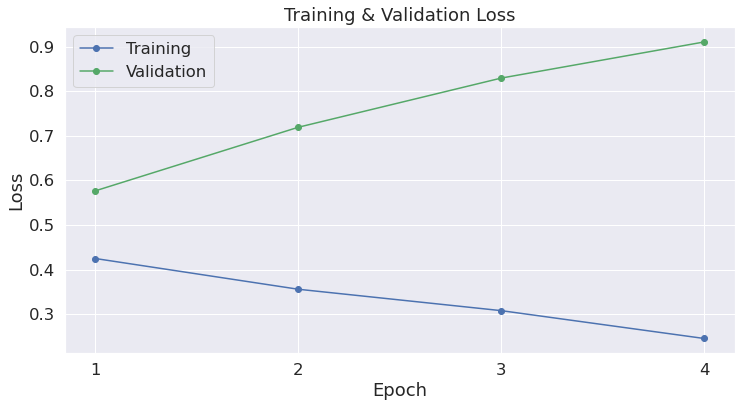

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import os
base_dir = os.getcwd() + '/'
print('Base Dir:', base_dir)

Base Dir: /home/local/ASUAD/mkarami/Documents/Motivational Factors/


In [ ]:
if not os.path.exists(base_dir+'cache/sent_emb_politifact.pt'):
    sentence_embedding = []
    model.eval()

    for i in tqdm(range(len(input_ids_politifact))):
        # print(type(input_ids_politifact[0]))
        # print(input_ids_politifact.size())
        # print(segments_ids[0])

        input_ids_politifact = input_ids_politifact.to(device)
        # segments_ids = segments_ids.to(device)
        # model = model.to(device)
        a=torch.reshape(input_ids_politifact[i], (1,len(input_ids_politifact[i])))
        # b=torch.reshape(segments_ids[0], (1,len(segments_ids[0])))
        # print(b.size())
        with torch.no_grad():

            outputs = model(a, token_type_ids=None)
            # Evaluating the model will return a different number of objects based on 
            # how it's  configured in the `from_pretrained` call earlier. In this case, 
            # becase we set `output_hidden_states = True`, the third item will be the 
            # hidden states from all layers. See the documentation for more details:
            # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
            (logits, hidden_states) = outputs
        token_vecs = hidden_states[-2][0]

        # Calculate the average of all 22 token vectors.
        sentence_embedding.append(torch.mean(token_vecs, dim=0))
    torch.save(sentence_embedding, base_dir+'cache/sent_emb_politifact.pt')
    
else:
    print("Sent Emb Exists...")
    sentence_embedding = torch.load(base_dir+'cache/sent_emb_politifact.pt')




100%|██████████| 18893/18893 [02:31<00:00, 124.43it/s]


In [ ]:
# torch.save(sentence_embedding, '/home/local/ASUAD/mkarami/Documents/cache/'+'sent_emb_politifact')

In [ ]:
len(sentence_embedding[0])

768

In [ ]:
import pickle
features_politifact_fake_users = pickle.load(open(base_dir +'/Filtered_date_users_with_three_tweets_or_more/features_politifact_fake_users.pkl', 'rb'))
features_politifact_real_users = pickle.load(open(base_dir +'/Filtered_date_users_with_three_tweets_or_more/features_politifact_real_users.pkl', 'rb'))
features_politifact_fake_users = features_politifact_fake_users.values()
features_politifact_fake_users = [list(x.values()) for x in features_politifact_fake_users]
features_politifact_real_users = features_politifact_real_users.values()
# features_politifact_real_users = [x.values() for x in features_politifact_real_users]
features_politifact_real_users = [list(x.values()) for x in features_politifact_real_users]


In [ ]:
len(features_politifact_fake_users)

6322

In [ ]:
politifact_features = []
y_labels = []
for i in range(len(features_politifact_fake_users)):
    politifact_features.append(features_politifact_fake_users[i])
    y_labels.append(1)
for i in range(len(features_politifact_real_users)):
    politifact_features.append(features_politifact_real_users[i])
    y_labels.append(0)
politifact_features = [[v if v is not None else 0 for v in nested] for nested in politifact_features]
# for i in range(len(politifact_features)):
politifact_features[0]

[0.006686478454680535,
 0.009658246656760773,
 0.0014858841010401188,
 0.009658246656760773,
 0.0014858841010401188,
 0.0029717682020802376,
 0,
 211,
 5.882352941176471,
 0.30214285714285716,
 0.49]

In [ ]:
X_Politifact_concated_ver = []
for i in range(len(politifact_features)):
    X_Politifact_concated_ver.append(politifact_features[i]+sentence_embedding[i].tolist())

In [ ]:
len(X_Politifact_concated_ver[0])

779

In [ ]:
# for batch in valid_loader:
#     b_input_ids = batch[0].to(device)
#     b_input_mask = batch[1].to(device)
#     b_labels = batch[2].to(device)
#     print(len(b_input_ids))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_Politifact_concated_ver, y_labels, test_size=0.1, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(1000,100))
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(1000, 100))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)
print("Acc:", accuracy_score(y_test, y_pred))
print("Prec:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Acc: 0.9
Prec: 0.9064327485380117
Recall: 0.7673267326732673
F1: 0.8310991957104559


In [ ]:
## BERT
# Acc: 0.7861286919831223
# Prec: 0.5947784810126583
# Recall: 0.6490330520393812
# F1: 0.5802285208930782


## BERT + Features
# Acc: 0.9
# Prec: 0.9064327485380117
# Recall: 0.7673267326732673
# F1: 0.8310991957104559